In [7]:
#################################################
#created the 18/04/2018 12:57 by Alexis Blanchet#
#################################################

In [8]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import scipy.stats
import matplotlib
import plotly.offline as offline
import plotly.graph_objs as go

In [9]:
def load_timeserie(file):
    data_file = open(file, 'r',os.O_NONBLOCK)
    data_file = data_file.read()
    datas = data_file.split('\n')
    data = [float(x) for x in datas[:-1]]
    return data
    

real_data = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/clean data/clean_data_test.csv',index_col=0)

In [10]:
real_data.head()

,values
1,1843792.72
2,1914849.04
3,1977719.98
4,2022994.24
5,2069380.62


let's no create some features.

In [11]:
from pandas import Series
from pandas import DataFrame
from pandas import concat

def add_noise(l):
    res = []
    for i in range(len(l)):
        res.append(l[i])
        m = max(res[-1]/10**8,1)
        res.append(np.random.normal(res[-1],m))
    return res

NOISE_LEVEL = 0
def shift_preprocess(data,noise_level=NOISE_LEVEL):
    temps = data['values'].values
    for i in range(noise_level):
        temps = add_noise(temps)
    temps = DataFrame(temps)
    dataframe = concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
    dataframe.columns = ['t-3', 't-2', 't-1', 't']
    dataframe = dataframe.drop(dataframe.index[[0,1,2]])
    print(dataframe.head())
    return dataframe

In [12]:
df = shift_preprocess(real_data)

          t-3         t-2         t-1           t
3  1843792.72  1914849.04  1977719.98  2022994.24
4  1914849.04  1977719.98  2022994.24  2069380.62
5  1977719.98  2022994.24  2069380.62  2103164.94
6  2022994.24  2069380.62  2103164.94  2136791.76
7  2069380.62  2103164.94  2136791.76  2151169.90


In [13]:
offline.plot({'data': [{'y': df['t'],'x':[(i)/((2**NOISE_LEVEL)*60) for i in range(len(df['t']))]}], 
               'layout': {'title': 'Test Plot', 
                          'font': dict(size=16)}},
             image='png')
                       

'file:///home/alexis/Bureau/stage/Project/Time-series/temp-plot.html'

In [14]:
def processing(dataframe,plot_dist=False):   
    dataframe["diff t t-1"]=dataframe["t"]-dataframe["t-1"]
    dataframe["diff t t-2"]=dataframe["t"]-dataframe["t-2"]
    dataframe["diff t t-3"]=dataframe["t"]-dataframe["t-3"]
    dataframe["diff t-1 t-2"]=dataframe["t-1"]-dataframe["t-2"]
    dataframe["diff t-1 t-3"]=dataframe["t-1"]-dataframe["t-3"]
    dataframe["diff t-2 t-3"]=dataframe["t-2"]-dataframe["t-3"]
    dataframe["diff t t-1"]=dataframe["t"]-dataframe["t-1"]
    dataframe["mean"]=(dataframe["t"]+dataframe["t-1"]+dataframe["t-2"]+dataframe["t-3"])/3
    dataframe["distance to mean"] = dataframe["t"] - dataframe["mean"]
    dataframe["pente t t-2"] = dataframe["diff t t-2"]/2
    dataframe["pente t t-3"] = dataframe["diff t t-3"]/3
    dataframe["pente t-1 t-3"] = dataframe["diff t-1 t-3"]/2

    x = dataframe["diff t t-1"]
    m = np.mean(x)
    sd = sum([(y-m)**2 for y in x])/(len(x)-1)
    print("moyenne: %s   standard deviation: %s" %(str(m),str(sd)))

    d = scipy.stats.norm(m, sd)
    time = [((i)/((2**NOISE_LEVEL)*60)) for i in range(len(x))]
    prob = [ d.pdf(y) for y in x]
    dist = [ d.cdf(y) for y in x]
    dataframe["probability"] = prob
    dataframe["distribution"] = dist
    print(np.argmin(prob))
    
    if(plot_dist == False):
        offline.plot({'data': [{'y': prob,'x':[(i)/((2**NOISE_LEVEL)*60) for i in range(len(df['t']))]}], 
                   'layout': {'title': 'probability plot', 
                              'font': dict(size=16)}},
                 image='png')

    else:   
        offline.plot({'data': [{'y': dist,'x':[(i)/((2**NOISE_LEVEL)*60) for i in range(len(df['t']))]}], 
                   'layout': {'title': 'distribution Plot', 
                              'font': dict(size=16)}},
                 image='png')

    
    plt.figure(figsize=(25,15))
    plt.subplot(2, 1, 1)
    plt.plot(time,prob, '-')
    ax=plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
    plt.title('probability and distribution of the change in the number of viewers')
    
    plt.subplot(2, 1, 2)
    plt.plot(time,dist, '.-')
    ax=plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
    plt.xlabel('time (arbitrary)')
    
    return dataframe


moyenne: 194.46704244954483   standard deviation: 21251031650.774204
1077


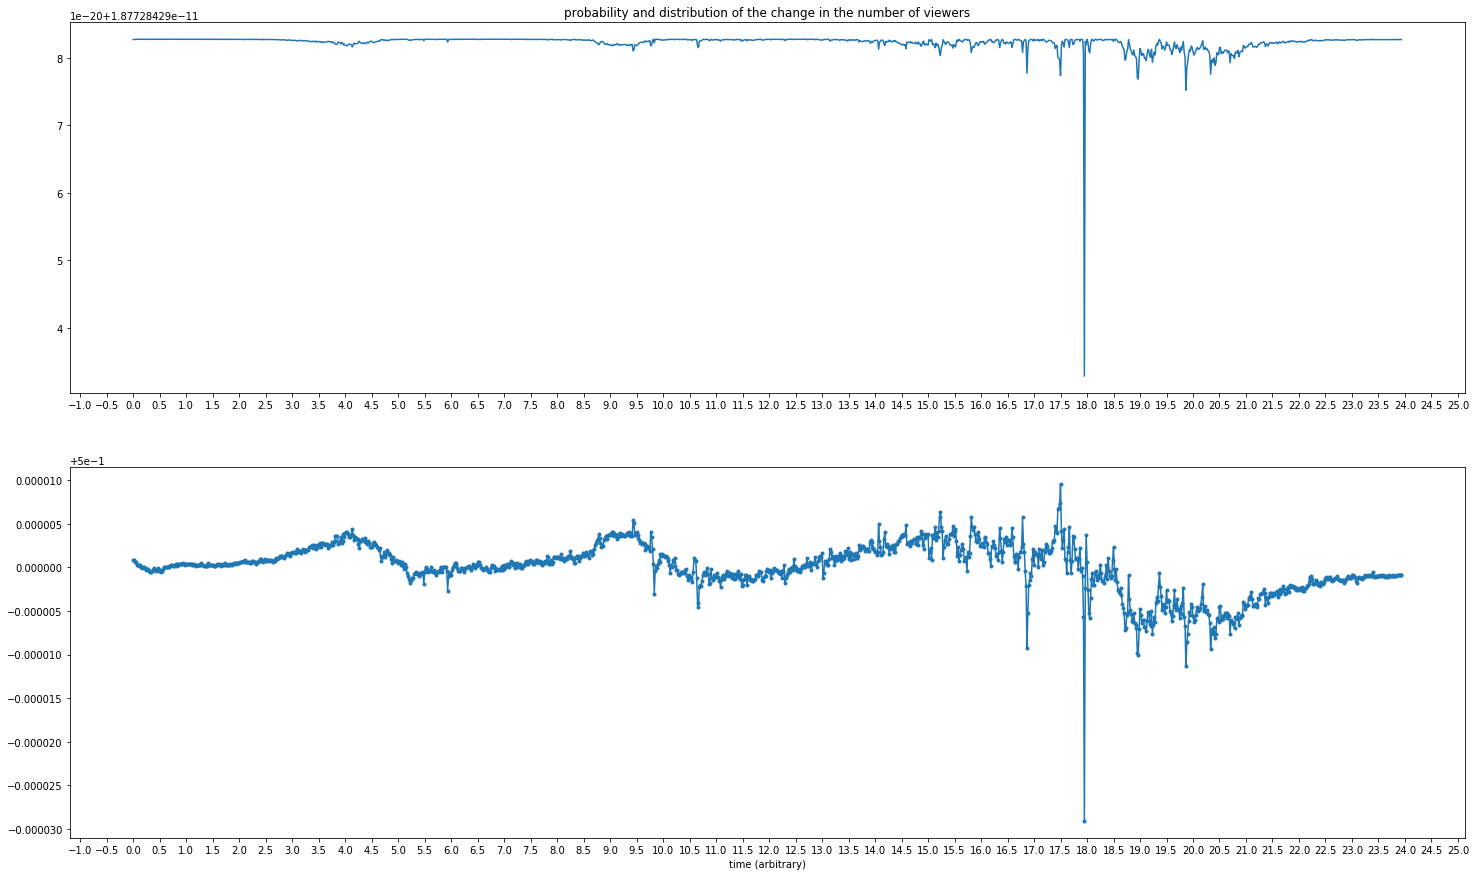

In [15]:
df = processing(df)

In [16]:
def annomalie_detection(df,automatic_threshold = True):
    '''
    prend en entrée un DataFrame
    renvoie en sortie une liste de points ou il y a annomalie
    les threshold sont a déterminer manuellement pour le moment
    on peut cependant essayer de les fixer de manière automatique
    en fonction de l'historique de la chaîne/departement/regroupement(csp)
    '''
    if(automatic_threshold):
        l = []
        res = []
        names = df.columns
        for n in names:
            if any(c==n for c in ("t", "t-1", "t-2","t-3")):
                pass
            else:
                df[n]=df[n]/df[n].max()
        for n in names:
            if any(c==n for c in ("t", "t-1", "t-2",'t-3')):
                pass
            else:
                df_temp = df.where(df[n]>0.5)
                l.append(df_temp['t'].values)
    else:
        pass
        #TODO:Fix every threshold by yourself...i'll let you do it
    for i in df['t'].values:
        if(i%100 == 0): print(i)
        count = 0
        for j in range(len(l)):
            if any(c == i for c in l[j]):
                count+=1
        res.append(count)
    return res
annomalies = annomalie_detection(df)    

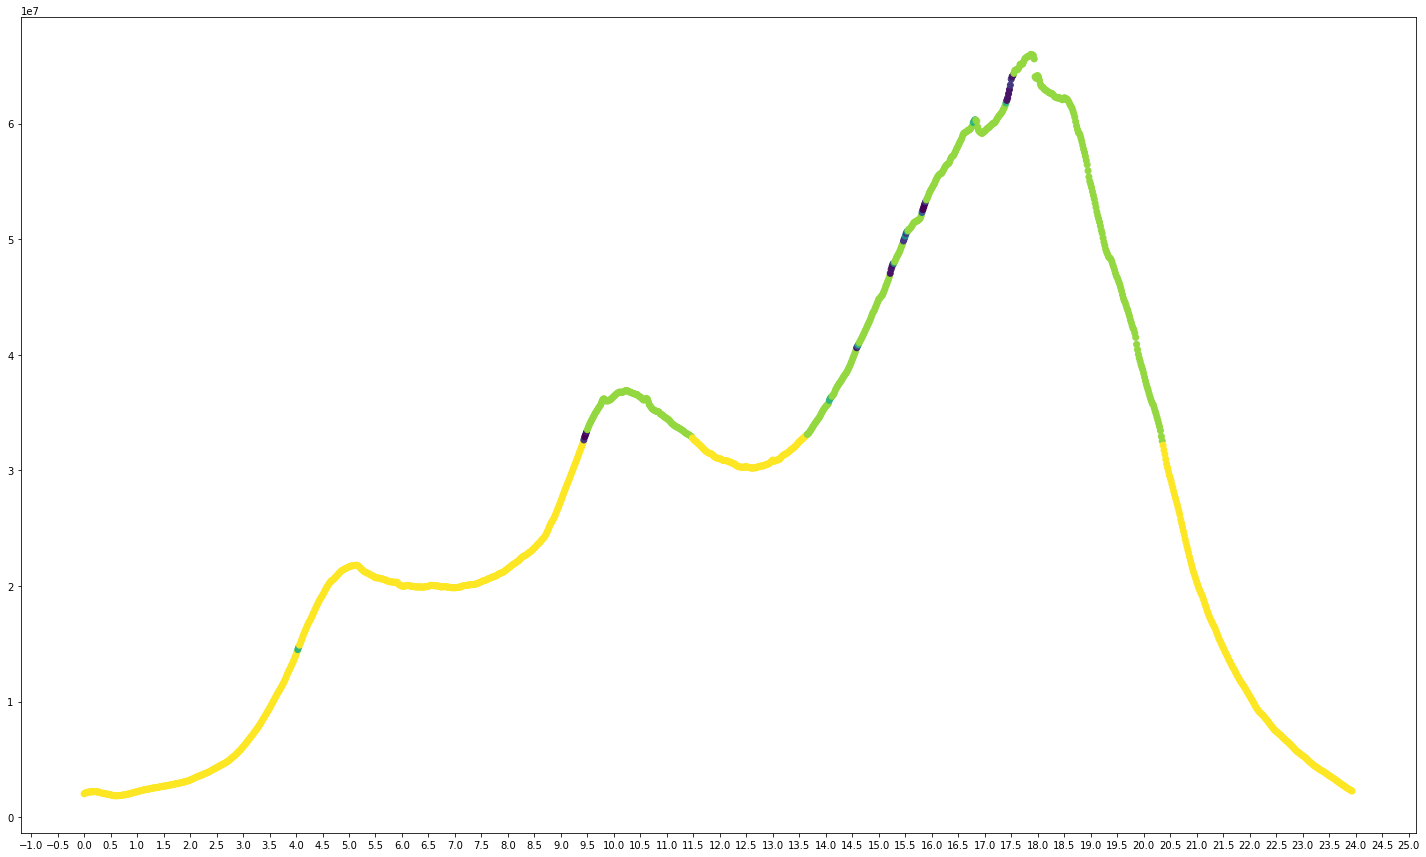

In [23]:
c = np.cos([0.3*b for b in annomalies])
x = real_data.values[3:]
fig, ax = plt.subplots(figsize=(25,15))
ax.scatter([i/60 for i in range(len(x))],x,c=c)
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
plt.savefig("colored_trend.png")

In [18]:
def sum_list(a,b):
    c = [x+y for x,y in zip(a,b)]
    return c

In [19]:
#####################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
######################################################
### XGB modeling
params = {'eta': 0.02,
          'max_depth': 9, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':5,
          'alpha':2,
          'objective': 'multi:softprob',
          'num_class':3,
          'eval_metric': 'mlogloss',
          'seed': 99,
          'silent': False}
params2 = {'eta': 0.02,
          'max_depth': 8, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':5,
          'alpha':1,
          'objective': 'multi:softprob',
          'num_class':3,
          'eval_metric': 'mlogloss',
          'seed': 99,
          'silent': False}
######################################################
class Classifier(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
        self.clf1 = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        self.clf2 = xgb.train(params2, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        res = [ sum_list(a,b) for a,b in zip(res1,res2)]
        return res
    